### Import modules

In [11]:
import pickle
import pandas as pd
import numpy as np
import pymysql.cursors
import sys
import matplotlib.pyplot as plt

### Connect to database and preview the dataframe

In [12]:
URI = "database-test1.ckvmcnbipeqn.eu-west-1.rds.amazonaws.com"
PORT = 3306
DB = "dbbikes"
USER = "picto"
PASSWORD = "Comp30830"
try:
    conn = pymysql.connect(host=URI, user=USER, password=PASSWORD, port=PORT, database=DB)

    cursor = conn.cursor()
    sql = "SELECT * FROM db_bikes.station_new_availability"
    cursor.execute(sql)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df_bikes_availability = pd.DataFrame(results, columns= columns)
    print("Database connected successfully")
except Exception as e:
    sys.exit(e)

df_bikes_availability.tail()

Database connected successfully


,number,available_bikes,available_bike_stands,last_update
1083223,39,5,15,2023-04-15 18:09:04
1083224,83,11,29,2023-04-15 18:09:29
1083225,92,28,12,2023-04-15 18:03:04
1083226,21,29,1,2023-04-15 18:10:41
1083227,88,12,18,2023-04-15 18:08:51


### Add columns

In [13]:

df_bikes_availability['weekday'] = df_bikes_availability.last_update.dt.day_name()
df_bikes_availability.loc[df_bikes_availability.last_update >= pd.Timestamp('2023-03-26 01:00:00'), 'hour'] = df_bikes_availability.last_update.dt.hour + 1
df_bikes_availability.loc[df_bikes_availability.last_update < pd.Timestamp('2023-03-26 01:00:00'), 'hour'] = df_bikes_availability.last_update.dt.hour
df_bikes_availability['total_stands'] = df_bikes_availability['available_bikes'] + df_bikes_availability['available_bike_stands']

In [14]:
df_bikes_availability.tail()

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands
1083223,39,5,15,2023-04-15 18:09:04,Saturday,19.0,20
1083224,83,11,29,2023-04-15 18:09:29,Saturday,19.0,40
1083225,92,28,12,2023-04-15 18:03:04,Saturday,19.0,40
1083226,21,29,1,2023-04-15 18:10:41,Saturday,19.0,30
1083227,88,12,18,2023-04-15 18:08:51,Saturday,19.0,30


### Check null data

In [15]:
df_bikes_availability[df_bikes_availability.isnull().values==True]

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands


### Check duplicate data

In [16]:
# df_bikes_availability.duplicated().sum()
# include_duplicate = df_bikes_availability[df_bikes_availability.duplicated(keep=False)].shape[0]
# print("There are {} duplicate rows including the first row.".format(include_duplicate))
# include_duplicate_lines = df_bikes_availability[df_bikes_availability.duplicated(keep=False)]
# print(include_duplicate_lines)

### descriptive statistics

In [17]:
# check all of the data types
print(df_bikes_availability.dtypes)

number                            int64
available_bikes                   int64
available_bike_stands             int64
last_update              datetime64[ns]
weekday                          object
hour                            float64
total_stands                      int64
dtype: object


In [18]:
# modify the data type of weekday to category
df_bikes_availability['weekday'] = df_bikes_availability['weekday'].astype('category')
df_bikes_availability.select_dtypes(['category']).describe().T

,count,unique,top,freq
weekday,1083228,7,Wednesday,163427


In [19]:
numeric_columns = df_bikes_availability.select_dtypes(['int64']).columns
df_bikes_availability[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
number,1083228.0,58.824561,34.115466,1.0,29.0,58.5,89.0,117.0
available_bikes,1083228.0,11.437393,9.452269,0.0,3.0,10.0,17.0,40.0
available_bike_stands,1083228.0,20.097619,10.935634,0.0,12.0,20.0,29.0,40.0
total_stands,1083228.0,31.535012,8.025418,0.0,29.0,30.0,40.0,40.0


In [20]:
df_bikes_availability.select_dtypes(['datetime64[ns]']).describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max
last_update,1083228,2023-03-30 04:00:06.467464192,2023-03-13 14:37:42,2023-03-21 21:10:23,2023-03-30 03:58:14.500,2023-04-07 10:45:21.249999872,2023-04-15 18:10:45


### plot

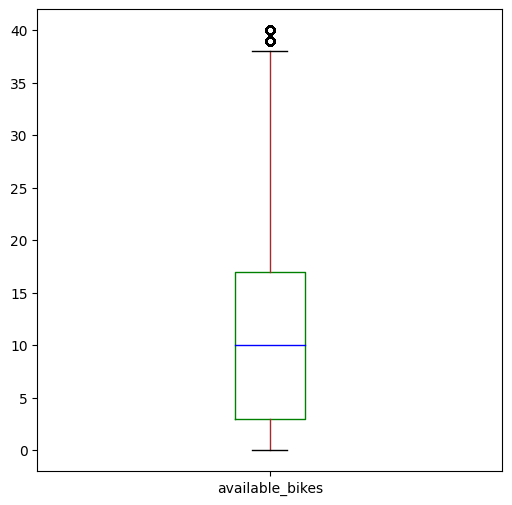

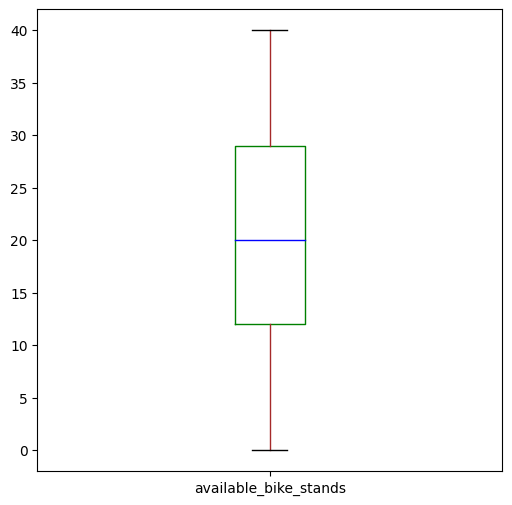

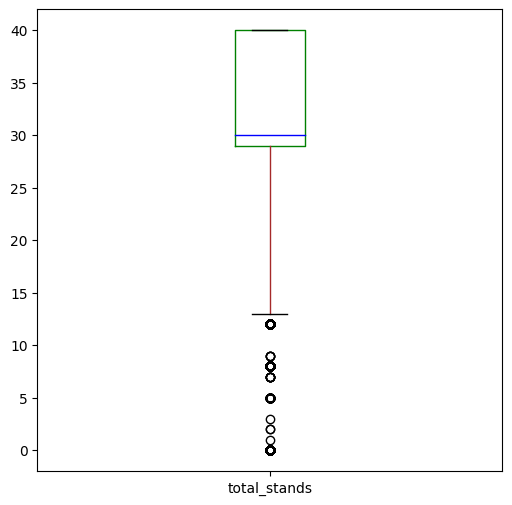

In [30]:
station_info = {'available_bikes','available_bike_stands', 'total_stands'}
color = {'boxes': 'Green', 'whiskers': 'Brown', 'medians': 'Blue', 'caps': 'Black'}

for col in station_info:
    f = df_bikes_availability[col].plot(color=color, kind='box', figsize=(6, 6))
    plt.show()

array([[<AxesSubplot:title={'center':'available_bikes'}>,
        <AxesSubplot:title={'center':'available_bike_stands'}>],
       [<AxesSubplot:title={'center':'total_stands'}>, <AxesSubplot:>]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

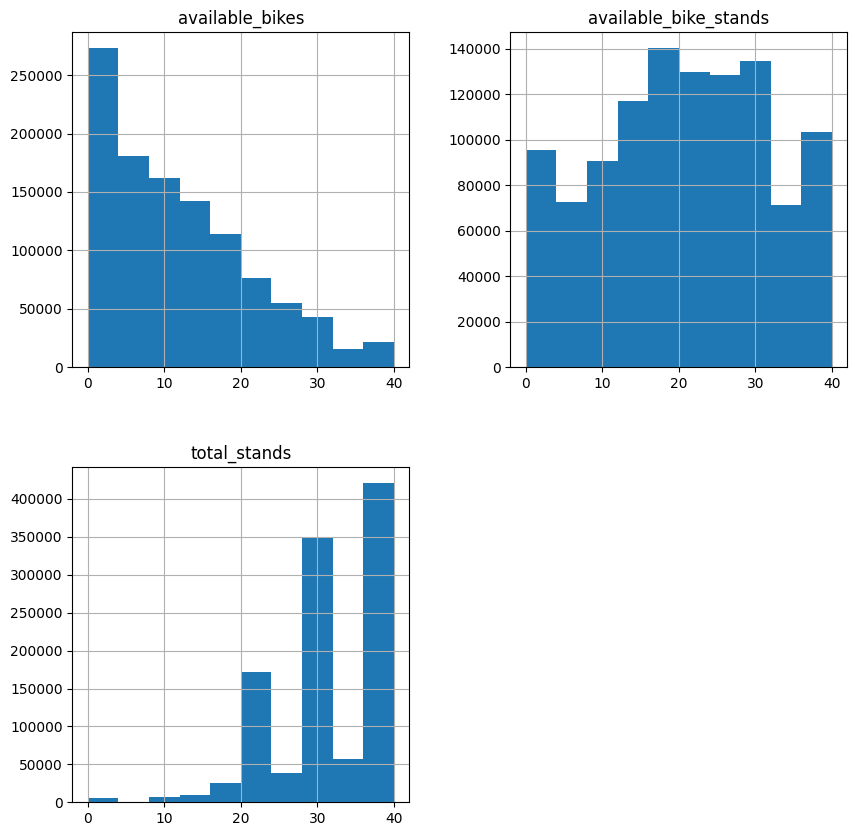

In [32]:
plt.figure()
df_bikes_availability[list(station_info)].hist(figsize=(10, 10))

<AxesSubplot:xlabel='available_bikes', ylabel='available_bike_stands'>

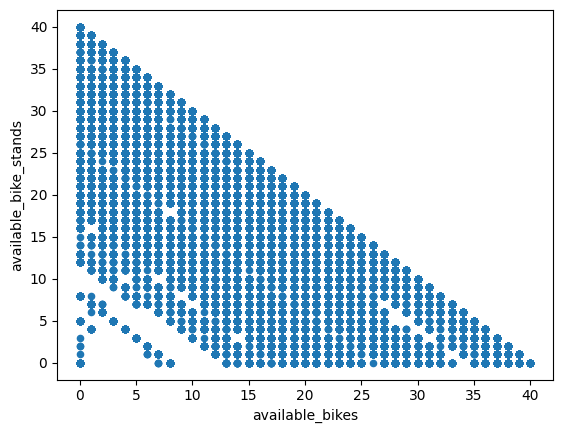

In [33]:
df_bikes_availability.plot(kind='scatter', x='available_bikes', y='available_bike_stands')

<AxesSubplot:>

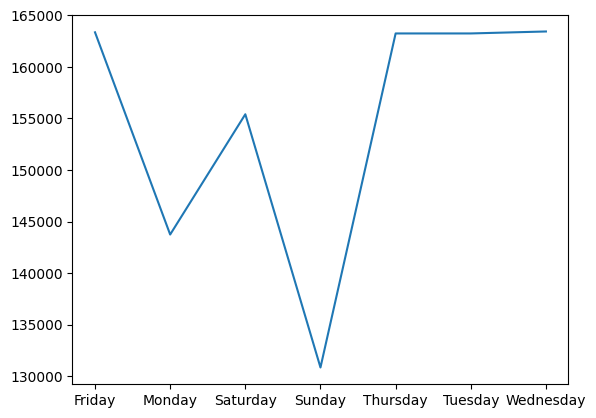

In [34]:
df_bikes_availability.weekday.value_counts().sort_index().plot()

### store the fixed station stands

In [36]:
df_station = pd.DataFrame(df_bikes_availability, columns=['number', 'total_stands'])
df_station = df_station.drop_duplicates(['number'])
df_station = df_station.reset_index().drop('index',axis=1)
df_station = df_station.sort_values(['number'], ascending=[True])
df_station

,number,total_stands
16,1,31
83,2,20
104,3,20
44,4,20
39,5,40
...,...,...
31,113,40
28,114,40
56,115,30
36,116,30


In [37]:
df_station['total_stands'][df_bikes_availability['number'] == 2].iloc[0]

20

In [39]:
station_total_stands = dict()
for ID in df_station['number']:
    station_total_stands[ID] = df_station['total_stands'][df_station['number'] == ID].iloc[0]
print(station_total_stands)

{1: 31, 2: 20, 3: 20, 4: 20, 5: 40, 6: 20, 7: 29, 8: 30, 9: 24, 10: 16, 11: 30, 12: 20, 13: 30, 14: 30, 15: 13, 16: 20, 17: 20, 18: 30, 19: 30, 20: 30, 21: 30, 22: 19, 23: 30, 24: 20, 25: 30, 26: 20, 27: 20, 28: 30, 29: 29, 30: 20, 31: 20, 32: 30, 33: 23, 34: 30, 35: 29, 36: 40, 37: 30, 38: 40, 39: 20, 40: 21, 41: 20, 42: 30, 43: 30, 44: 30, 45: 30, 47: 40, 48: 40, 49: 40, 50: 40, 51: 40, 52: 32, 53: 40, 54: 33, 55: 34, 56: 40, 57: 23, 58: 40, 59: 20, 60: 30, 61: 25, 62: 40, 63: 35, 64: 40, 65: 40, 66: 40, 67: 40, 68: 40, 69: 40, 71: 40, 72: 31, 73: 30, 74: 30, 75: 40, 76: 38, 77: 29, 78: 40, 79: 27, 80: 40, 82: 8, 83: 40, 84: 30, 85: 35, 86: 38, 87: 38, 88: 30, 89: 40, 90: 40, 91: 30, 92: 40, 93: 40, 94: 40, 95: 40, 96: 30, 97: 40, 98: 40, 99: 30, 100: 25, 101: 30, 102: 40, 103: 40, 104: 40, 105: 36, 106: 40, 107: 40, 108: 35, 109: 29, 110: 40, 111: 40, 112: 30, 113: 40, 114: 40, 115: 30, 116: 30, 117: 39}


In [46]:
# descriptive statistic of station data
df_station.describe().T

,count,mean,std,min,25%,50%,75%,max
number,114.0,58.824561,34.266071,1.0,29.25,58.5,88.75,117.0
total_stands,114.0,31.789474,7.824936,8.0,29.00,30.0,40.00,40.0


In [41]:
len(station_total_stands)

114

### save the data into csv

In [42]:
df_bikes_availability.to_csv('df_bikes_availability.csv',index=None)

In [44]:
df_station.to_csv('df_station.csv',index=None)

### weather data

In [47]:
try:
    sql = "SELECT * FROM db_bikes.dublin_new_weather"
    cursor.execute(sql)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df_curr_weather = pd.DataFrame(results, columns= columns)
    print("Database connected successfully")
except Exception as e:
    sys.exit(e)

df_curr_weather.tail()

Database connected successfully


,dt,sunrise,sunset,temp,feels_like,pressure,humidity,uvi,clouds,visibility,wind_speed,wind_deg,weather_description,temp_min,temp_max
8738,2023-04-15 17:48:39,2023-04-15 05:26:13,2023-04-15 19:23:41,284.96,283.92,1020,66,0.14,75,10000,5.66,210,broken clouds,275.91,285.28
8739,2023-04-15 17:53:39,2023-04-15 05:26:13,2023-04-15 19:23:41,284.96,283.92,1020,66,0.14,75,10000,5.66,210,moderate rain,275.91,285.28
8740,2023-04-15 17:58:39,2023-04-15 05:26:13,2023-04-15 19:23:41,284.96,283.92,1020,66,0.14,75,10000,5.66,210,light rain,275.91,285.28
8741,2023-04-15 18:03:39,2023-04-15 05:26:13,2023-04-15 19:23:41,284.99,283.90,1020,64,0.14,75,10000,4.12,170,broken clouds,275.91,285.28
8742,2023-04-15 18:08:39,2023-04-15 05:26:13,2023-04-15 19:23:41,285.01,283.92,1020,64,0.14,75,10000,4.12,170,light rain,275.91,285.28
